# COMBINED HEAT & POWER PLANT (CHP):


    Combined heat and power (CHP) systems, also known as cogeneration, generate electricity and useful thermal energy in a single, integrated system. CHP is not a technology, but an approach to applying technologies. Heat that is normally wasted in conventional power generation is recovered as useful energy, which avoids the losses that would otherwise be incurred from separate generation of heat and power. While the conventional method of producing usable heat and power separately has a typical combined efficiency of 45 percent, CHP systems can operate at levels as high as 80 percent.The following Fig. shows the flow diagram of a CHP unit.
    

###  Decision Tree, Random Forest implementations

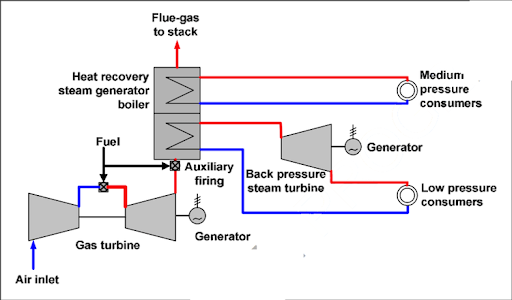

In [1]:
from pathlib import Path
from IPython.display import Image, display

display(Image(filename = str(Path().resolve().parent) + "/img.png", width=654, height=474))

We are trying to predic the full load of electrical power output of a base load operated
combined cycle power plant (CHP) using machine learning methods like linearreg, decision tree, random forest and neural networks.
The goal of the project is formulating an optimization method for the units operation based on studying the subsequent of the provided variables.
The provided data set is fully labled and has 5 features and almost 48000 instances of recorded data.

In [2]:
import pandas as pd

def load_chp_data():
    return pd.read_excel("../chp.xlsx")

chp = load_chp_data()
chp.head()

Ambient_T  Exhaust_Volume  Atmospheric_P  Relative Humidity  Electric_Power
0      14.96           41.76        1024.07              73.17          463.26
1      25.18           62.96        1020.04              59.08          444.37
2       5.11           39.40        1012.16              92.14          488.56
3      20.86           57.32        1010.24              76.64          446.48
4      10.82           37.50        1009.23              96.62          473.90

Next we should visualize the data to have a look.

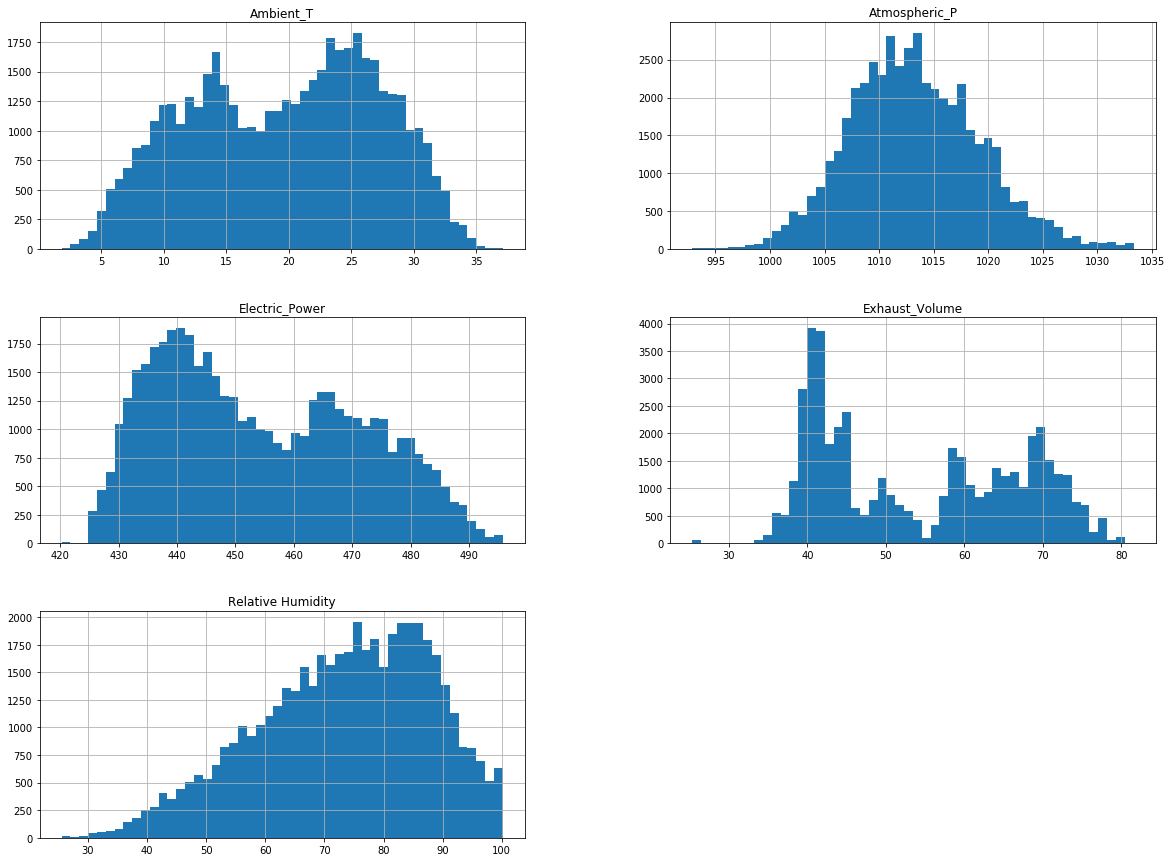

In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt

chp.hist(bins=50, figsize=(20,15))
plt.show()

The original data set is broken 80% to 20% for aquiring a test set. data points are selected randomly.

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(chp, chp["Atmospheric_P"]):
    strat_train_set = chp.loc[train_index]   #TRAIN_SET
    strat_test_set = chp.loc[test_index]     #TEST_SET


Now we try to understand (by visualisation) the temp/pressure range of plant operation data


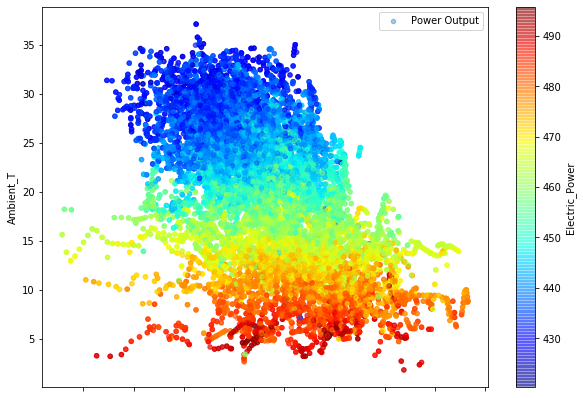

In [5]:
%matplotlib inline 
import matplotlib.pyplot as plt

chp = strat_train_set.copy()
chp.plot(kind="scatter", x="Atmospheric_P", y="Ambient_T", alpha=0.4,label="Power Output", figsize=(10,7),
c="Electric_Power", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()
plt.show()

Here we dig for some linear correlations in data

In [6]:
correlations = chp.corr()
correlations["Electric_Power"].sort_values(ascending=False)

Electric_Power       1.000000
Atmospheric_P        0.517521
Relative Humidity    0.389102
Exhaust_Volume      -0.870120
Ambient_T           -0.948504
Name: Electric_Power, dtype: float64

Pairwase scatter plot of parameters shown below.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf01537c50>,
      dtype=object)

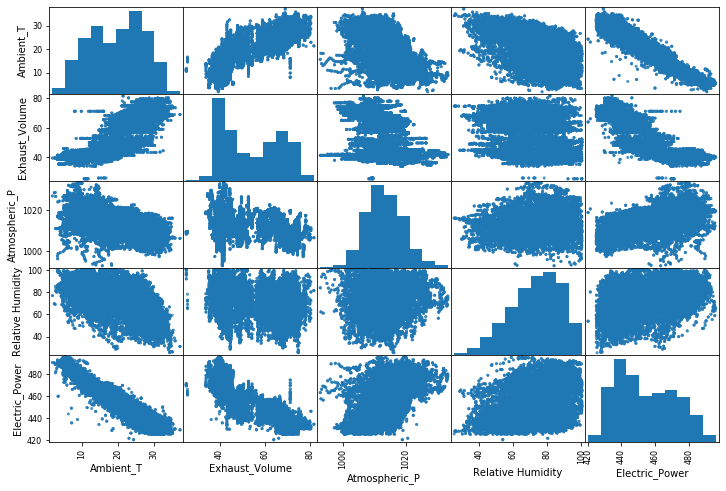

In [7]:
%matplotlib inline 
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

scatter_matrix(chp, figsize=(12, 8))

A closer look at Atmospheric Pressure & Ambient Temperature correlation with power output

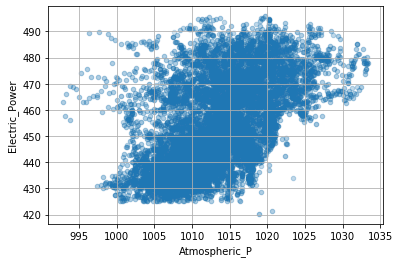

In [8]:
chp.plot(kind="scatter", x="Atmospheric_P", y="Electric_Power",
alpha=0.1, grid=1)

In [9]:
chp.plot(kind="scatter", x="Ambient_T", y="Electric_Power",
alpha=0.1, grid=1)

Data undergoes some transformation using Scikit-Learn’s pipeline class

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

chping = strat_train_set.drop("Electric_Power", axis=1)
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])
chping_num_tr = num_pipeline.fit_transform(chping)


In [12]:
from sklearn.compose import ColumnTransformer

chping = strat_train_set.drop("Electric_Power", axis=1)
chping_labels = strat_train_set["Electric_Power"].copy()

num_attribs = list(chping)
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs)])
chping_prepared = full_pipeline.fit_transform(chping)

Initiating LinearRegression

In [13]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(chping_prepared, chping_labels)
##############
from sklearn.compose import ColumnTransformer

num_attribs = list(chping)
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
    ])

1st test of implementing the linear reggresion.

In [14]:
some_data = chping.iloc[:4]
some_labels = chping_labels.iloc[:4]
some_data_prepared = full_pipeline.fit_transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [474.93642364 472.30179557 432.51433158 437.64164862]
Labels: [464.57, 459.72, 448.01, 442.23]


Trying root mean square on results.

In [15]:
import numpy as np
from sklearn.metrics import mean_squared_error

chping_predictions = lin_reg.predict(chping_prepared)
mrsq = mean_squared_error(chping_labels, chping_predictions)
l_rmse = np.sqrt(mrsq)
l_rmse

4.531092524036867

### Decision Tree Regressor

Linear reg results are better than tipycally expected. Next we try for some nonlinearity in the data using Decision Trees.

In [18]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(chping_prepared, chping_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [19]:
chping_predictions = tree_reg.predict(chping_prepared)
tree_mse = mean_squared_error(chping_labels, chping_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

2.4839273025850123e-14

Looks too good to be true! Probabely an overfit. We should cross validate...
Implementing Scikit-Learn’s K-fold cross-validation feature.

In [20]:
#first a little code abstraction..
def display_scores(id):
    print("Scores:", id)
    print("Mean:", id.mean())
    print("Standard deviation:", id.std())

from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, chping_prepared, chping_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [0.71817823 0.11555463 0.20684536 0.13503496 0.20949302 0.30868176
 0.16131523 0.26095086 0.21411506 0.1377415 ]
Mean: 0.24679105884562738
Standard deviation: 0.16709329513838625


### Random Forest Regressor

And now let’s try RandomForestRegressor which works by training many Decision Trees on random subsets of
the features, then averaging out their predictions.

In [21]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10)
m = forest_reg.fit(chping_prepared, chping_labels)
scores = cross_val_score(forest_reg, chping_prepared, chping_labels,
                         cv=3, scoring="neg_mean_squared_error")
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [1.11511638 1.08663024 0.98629879]
Mean: 1.062681800510546
Standard deviation: 0.055248763216100484


Taking a second look at the data set, this could be predicted as the electric power shows very little sensitivity to the variables. At this stage our recommandation is introducing different variables to the model.

In [22]:
#doing some plotting here
print("Predictions:", forest_reg.predict((some_data_prepared)))
print("Labels:", list(some_labels))

Predictions: [474.428 471.32  433.912 439.002]
Labels: [464.57, 459.72, 448.01, 442.23]


Plotting the predictions to see whats what...

In [23]:
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import numpy as np

x = np.arange(0,100) 
a=list(chping_labels.iloc[:100])
b=list(forest_reg.predict(full_pipeline.fit_transform(chping.iloc[:100])))
plt.figure(figsize=(17,10))
plt.plot(x, a,"g-", label="Measured")
plt.plot(x, b,"b-", label="Predicted")
plt.legend(loc='upper left')
#plt.plot(x, a,"g-", label="Measured", x, b,"b-", label="Predicted")

At this point we are mildly satisfied with Random Forest results. The next step would be trying multi layer perceptron and/or neural network (CNN/RNN) architectures and time series.

In [16]:
import tensorflow as tf

class chpCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95.0% accuracy so cancelling training!")
      self.model.stop_training = True

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from keras.losses import mean_squared_error
from keras import backend as K
from keras import optimizers

adam = optimizers.adam(clipnorm=1.)
leaky_relu = LeakyReLU(alpha=0.1)

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))

model = Sequential()

model.add(Dense(4, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(8, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1))

model.compile(optimzer='nadam', loss=root_mean_squared_error, metrics=['accuracy'])

In [68]:
X_val = strat_test_set.drop("Electric_Power", axis=1)
y_val = strat_test_set["Electric_Power"].copy()

X_val = np.array(X_val)
y_val = np.array(y_val)
chping_prepared = np.array(chping_prepared)
chping_labels = np.array(chping_labels)

In [69]:
callbacks = chpCallback()
model.fit(x=chping_prepared, y=chping_labels, epochs=50,
          batch_size=32, validation_data=(X_val, y_val), callbacks=[callbacks])

Train on 38272 samples, validate on 9568 samples
Epoch 1/50
38272/38272 [==============================] - 23s 602us/sample - loss: 439.3711 - accuracy: 0.0000e+00 - val_loss: 1824.0140 - val_accuracy: 0.0000e+00
Epoch 2/50
38272/38272 [==============================] - 61s 2ms/sample - loss: 306.0992 - accuracy: 0.0000e+00 - val_loss: 29157.2371 - val_accuracy: 0.0000e+00
Epoch 3/50
38272/38272 [==============================] - 66s 2ms/sample - loss: 187.5851 - accuracy: 0.0000e+00 - val_loss: 44235.3647 - val_accuracy: 0.0000e+00loss: 197.4254 - 
Epoch 4/50
38272/38272 [==============================] - 62s 2ms/sample - loss: 156.8386 - accuracy: 0.0000e+00 - val_loss: 37557.8002 - val_accuracy: 0.0000e+00
Epoch 5/50
38272/38272 [==============================] - 68s 2ms/sample - loss: 142.6485 - accuracy: 0.0000e+00 - val_loss: 28526.5460 - val_accuracy: 0.0000e+00
Epoch 6/50
38272/38272 [==============================] - 69s 2ms/sample - loss: 136.4625 - accuracy: 0.0000e+00 - val

38272/38272 [==============================] - 66s 2ms/sample - loss: 86.9969 - accuracy: 0.0000e+00 - val_loss: 10.3623 - val_accuracy: 0.0000e+00
Epoch 48/50
38272/38272 [==============================] - 67s 2ms/sample - loss: 87.6107 - accuracy: 0.0000e+00 - val_loss: 11.2184 - val_accuracy: 0.0000e+00 ETA: 4s - loss: 87.5946 - accuracy - ETA
Epoch 49/50
38272/38272 [==============================] - 69s 2ms/sample - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 50/50
38272/38272 [==============================] - 69s 2ms/sample - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00


In [55]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             multiple                  20        
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
_________________________________________________________________
dense_28 (Dense)             multiple                  40        
_________________________________________________________________
dropout_20 (Dropout)         multiple                  0         
_________________________________________________________________
dense_29 (Dense)             multiple                  36        
_________________________________________________________________
dropout_21 (Dropout)         multiple                  0         
_________________________________________________________________
dense_30 (Dense)             multiple                 

In [56]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [57]:
x = np.arange(0,100) 
a=list(chping_labels[:100])
b=list(model.predict(full_pipeline.fit_transform(chping[:100])))
plt.figure(figsize=(15,10))
plt.plot(x, a,"g-", label="Measured")
plt.plot(x, b,"b-", label="Predicted")
plt.legend(loc='upper left')

In [26]:
from keras.losses import mean_squared_error
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))

model2 = Sequential()

model2.add(Dense(4, activation='relu'))
model2.add(Dropout(0.25))

model2.add(Dense(6, activation='relu'))
model2.add(Dropout(0.33))

model2.add(Dense(1))

model2.compile(optimzer='adam', loss = root_mean_squared_error, metrics=['accuracy'])

Using TensorFlow backend.


In [72]:
X_val = strat_test_set.drop("Electric_Power", axis=1)
y_val = strat_test_set["Electric_Power"].copy()

X_val = np.array(X_val)
y_val = np.array(y_val)
chping_prepared = np.array(chping_prepared)
chping_labels = np.array(chping_labels)

model2.fit(x=chping_prepared, y=chping_labels, epochs=100,
          batch_size=64, validation_data=(X_val, y_val), callbacks=[callbacks])

Train on 38272 samples, validate on 9568 samples
Epoch 1/100
38272/38272 [==============================] - 5s 121us/sample - loss: 450.7715 - accuracy: 0.0000e+00 - val_loss: 2687.6483 - val_accuracy: 0.0000e+00
Epoch 2/100
38272/38272 [==============================] - 4s 93us/sample - loss: 428.1478 - accuracy: 0.0000e+00 - val_loss: 15919.1234 - val_accuracy: 0.0000e+00
Epoch 3/100
38272/38272 [==============================] - 4s 115us/sample - loss: 363.8910 - accuracy: 0.0000e+00 - val_loss: 48697.0791 - val_accuracy: 0.0000e+00
Epoch 4/100
38272/38272 [==============================] - 4s 105us/sample - loss: 269.8059 - accuracy: 0.0000e+00 - val_loss: 70737.4437 - val_accuracy: 0.0000e+00
Epoch 5/100
38272/38272 [==============================] - 4s 116us/sample - loss: 220.4263 - accuracy: 0.0000e+00 - val_loss: 61064.3936 - val_accuracy: 0.0000e+00
Epoch 6/100
38272/38272 [==============================] - 6s 154us/sample - loss: 201.3795 - accuracy: 0.0000e+00 - val_loss: 4

38272/38272 [==============================] - 17s 434us/sample - loss: 119.4219 - accuracy: 0.0000e+00 - val_loss: 400.1031 - val_accuracy: 0.0000e+00
Epoch 100/100
38272/38272 [==============================] - 13s 329us/sample - loss: 119.8259 - accuracy: 0.0000e+00 - val_loss: 470.9887 - val_accuracy: 0.0000e+00


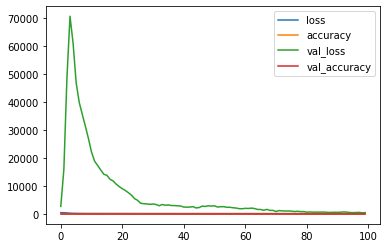

In [73]:
model2_loss = pd.DataFrame(model2.history.history)
model2_loss.plot()

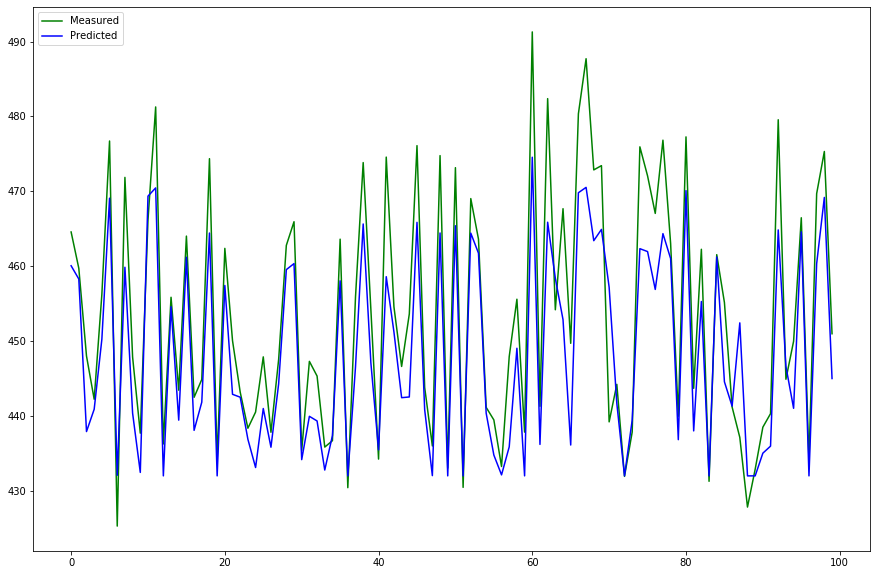

In [74]:
x = np.arange(0,100) 
a=list(chping_labels[:100])
b=list(model2.predict(full_pipeline.fit_transform(chping[:100])))
plt.figure(figsize=(15,10))
plt.plot(x, a,"g-", label="Measured")
plt.plot(x, b,"b-", label="Predicted")
plt.legend(loc='upper left')

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from keras.losses import mean_squared_error
from keras import backend as K
from keras import optimizers

leaky_relu = LeakyReLU(alpha=0.2)
adam = optimizers.adam(clipnorm=1.)

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))

model3 = Sequential()

model3.add(Dense(4, activation=leaky_relu, kernel_initializer="he_normal"))
model3.add(Dropout(0.33)
           
model3.add(Dense(6, activation='relu'))
model3.add(Dropout(0.25))

model3.add(Dense(1))

model3.compile(optimzer=adam, loss = root_mean_squared_error, metrics=['accuracy'])

SyntaxError: invalid syntax (<ipython-input-29-9f7985c59247>, line 18)

In [ ]:
X_val = strat_test_set.drop("Electric_Power", axis=1)
y_val = strat_test_set["Electric_Power"].copy()

X_val = np.array(X_val)
y_val = np.array(y_val)
chping_prepared = np.array(chping_prepared)
chping_labels = np.array(chping_labels)

callbacks = chpCallback()
model3.fit(x=chping_prepared, y=chping_labels, epochs=100,
          batch_size=64, validation_data=(X_val, y_val), callbacks=[callbacks])

In [35]:
model3_loss = pd.DataFrame(model3.history.history)
model3_loss.plot()

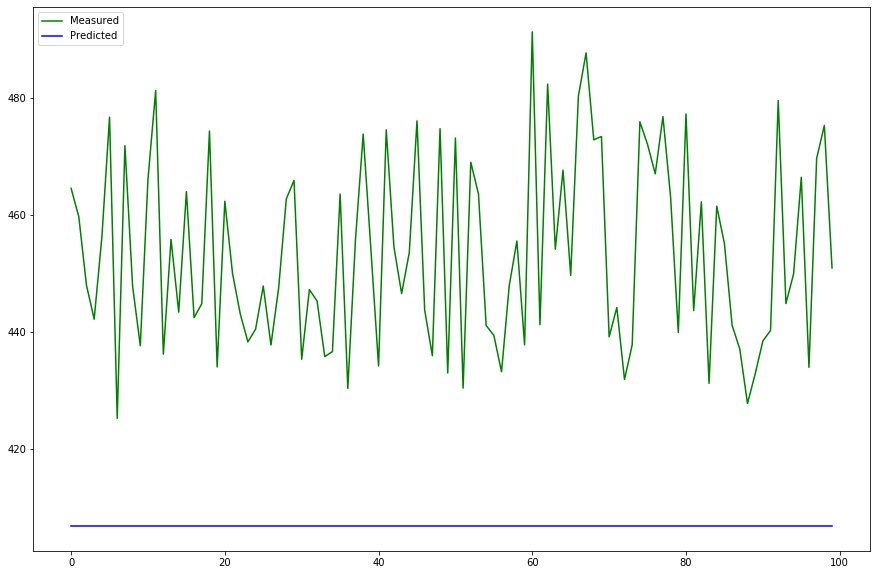

In [36]:
x = np.arange(0,100) 
a=list(chping_labels[:100])
b=list(model3.predict(full_pipeline.fit_transform(chping[:100])))
plt.figure(figsize=(15,10))
plt.plot(x, a,"g-", label="Measured")
plt.plot(x, b,"b-", label="Predicted")
plt.legend(loc='upper left')